# Redes Neurais na Análise de Sentimentos do IMDB
### Trabalho de Áleks Sebastian de Freitas Araújo, André Ferreira Santana, Dayan Freitas Alves,Douglas Moura Araújo, Lucas Aguiar dos Santos

#### Lembre-se de instalar todas as dependências necessárias usando %pip install [Nome]

## Parte 1: Análise de Sentimento via Pipeline, Agrupamento e Visualização

In [45]:
# Bibliotecas utilizadas

import pandas as pd
import matplotlib.pyplot as plt
import ast
from transformers import pipeline
from IPython.display import HTML, display
import numpy as np

In [46]:
# Carregar a base de dados

df = pd.read_csv("IMDB_reviews.csv")

In [47]:
# Etapa de Limpeza

df['Director'] = df['Director'].replace('sEthan CoenJoel Coen','Coen Brothers')\
                                 .replace('sJoel CoenEthan Coen','Coen Brothers')
df['Release Year'] = df['Release Year'].apply(pd.to_numeric)

df['Length'] = df['Length'].apply(lambda x: int(x.split('h')[0])*60 + int(x.split(' ')[-1].replace('m',''))
                                    if isinstance(x, str) and 'm' in str(x)
                                    else int(x.split('h')[0])*60 if isinstance(x, str)
                                    else None)

def ast_(x):
    try:
        return ast.literal_eval(x)
    except:
        return None

df['Cast'] = df['Cast'].apply(lambda x: ast_(x))
df['Votes'] = df['Votes'].str.replace(',', '').apply(pd.to_numeric, errors='coerce')
df['Gross'] = df['Gross'].apply(lambda x: float(x.replace('$','').replace('M',''))*10**6 
                                if 'M' in str(x) else None)
df['IMDB Rating'] = pd.to_numeric(df['IMDB Rating'], errors='coerce')
df['Rating By User'] = df['Rating By User'].apply(lambda x: int(x.split('/')[0]) 
                                                  if isinstance(x, str) else None)
df['Review Date'] = pd.to_datetime(df['Review Date'], errors='coerce')

# Garantir que a coluna de reviews não tenha valores nulos
df['Review Text'] = df['Review Text'].fillna("")

In [48]:
# Inicializar a pipeline de análise de sentimentos usando o modelo que retorna ratings em estrelas

sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def process_reviews_in_batches(reviews, batch_size=64):
    """
    Processa a lista de reviews em batches usando a pipeline, com truncation para 512 tokens.
    Retorna uma lista com os resultados.
    """
    results = []
    n = len(reviews)
    for i in range(0, n, batch_size):
        batch = reviews[i:i+batch_size]
        try:
            batch_results = sentiment_pipeline(batch, truncation=True, max_length=512, batch_size=batch_size)
        except Exception as e:
            batch_results = [None] * len(batch)
        results.extend(batch_results)
        print(f"Processados {min(i+batch_size, n)}/{n} reviews", end='\r')
    return results

c:\Users\dolby\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,Poster,Title,Release Year,IMDB Rating,Sentiment Rating
54,,The Shawshank Redemption,1994,9.300000,3.954774
88,,Heat,1995,8.300000,3.623333
5,,Who Framed Roger Rabbit,1988,7.700000,3.595070
85,,Harakiri,1962,8.600000,3.564593
37,,Collateral,2004,7.500000,3.539683
39,,Chinatown,1974,8.200000,3.519916
71,,High and Low,1963,8.400000,3.495935
104,,What Ever Happened to Baby Jane,1962,8.000000,3.464602
83,,Nebraska,2013,7.700000,3.460938
76,,Dial M for Murder,1954,8.200000,3.421053


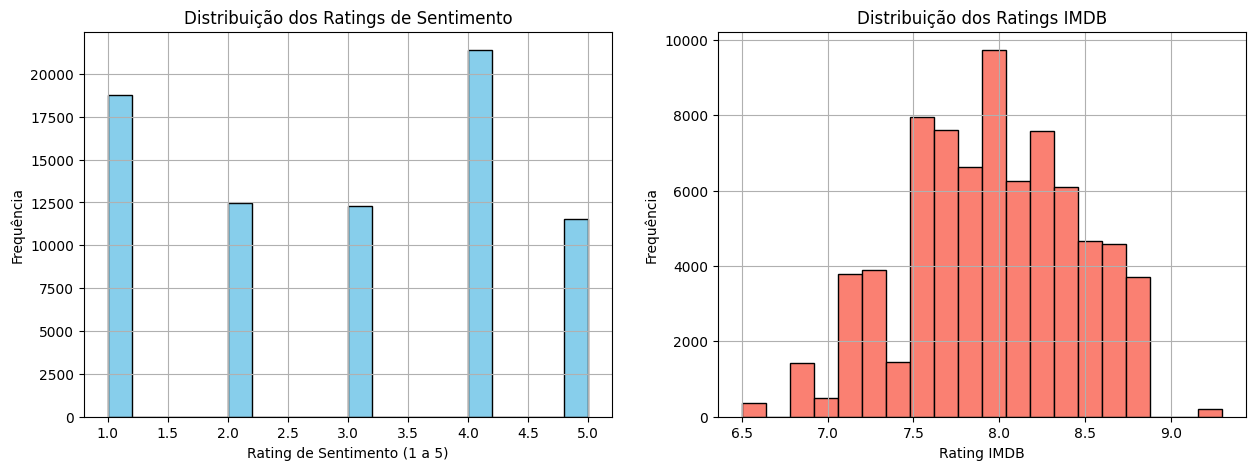

In [49]:
# Gerando os dados

# Converter os reviews para uma lista
reviews = df['Review Text'].tolist()

# Processar toda a base em batches
batch_results = process_reviews_in_batches(reviews, batch_size=64)

def extract_rating(result):
    """
    Extrai a nota (1 a 5) do label retornado, que vem no formato "X stars".
    """
    try:
        return int(result["label"][0])
    except Exception:
        return None

# Criar nova coluna com o rating de sentimento
df["Sentiment Rating"] = [extract_rating(res) if res is not None else None for res in batch_results]

# Agrupar por Poster e Title para calcular a média do IMDB e do Sentiment Rating
g = df.groupby(["Poster", "Title"]).agg({"IMDB Rating": "mean", "Sentiment Rating": "mean"}).reset_index()

# Mesclar informação do Release Year (utilizando linhas únicas)
g = g.merge(df.drop_duplicates(subset=["Poster", "Title", "Release Year"])[["Poster", "Title", "Release Year"]],
            on=["Poster", "Title"], how="left")

# Ordenar os filmes pelo Sentiment Rating de forma decrescente
g = g.sort_values("Sentiment Rating", ascending=False)
g = g[["Poster", "Title", "Release Year", "IMDB Rating", "Sentiment Rating"]]

# Converter a coluna 'Poster' para HTML para exibir as imagens (em ambiente Jupyter)
g["Poster"] = g.apply(lambda x: f'<img src="{x["Poster"]}" style="max-height:300px;max-width:300px;">', axis=1)

# Aplicar um background gradient para realçar as colunas numéricas
g = g.style.background_gradient(subset=["IMDB Rating", "Sentiment Rating"], cmap="Reds")

# Exibir a tabela formatada
display(HTML(g.to_html(escape=False)))

# Plotar distribuições dos ratings de sentimento e dos ratings IMDB
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df["Sentiment Rating"].dropna().hist(bins=20, ax=ax1, color="skyblue", edgecolor="black")
ax1.set_title("Distribuição dos Ratings de Sentimento")
ax1.set_xlabel("Rating de Sentimento (1 a 5)")
ax1.set_ylabel("Frequência")

df["IMDB Rating"].dropna().hist(bins=20, ax=ax2, color="salmon", edgecolor="black")
ax2.set_title("Distribuição dos Ratings IMDB")
ax2.set_xlabel("Rating IMDB")
ax2.set_ylabel("Frequência")

plt.show()

## Parte 2: Clustering com TF-IDF, K-Means e PCA (Método Clássico)

In [50]:
# Bibliotecas utilizadas

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [51]:
#Agrupamento de Reviews com K-Means e Visualização com PCA

# Vetorização TF-IDF dos textos dos reviews
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df["Review Text"])

# Aplicar K-Means para agrupar em 3 clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df["Cluster"] = kmeans.fit_predict(tfidf_matrix)

# Reduzir a dimensionalidade para 2 componentes com PCA para visualização
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_matrix.toarray())
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

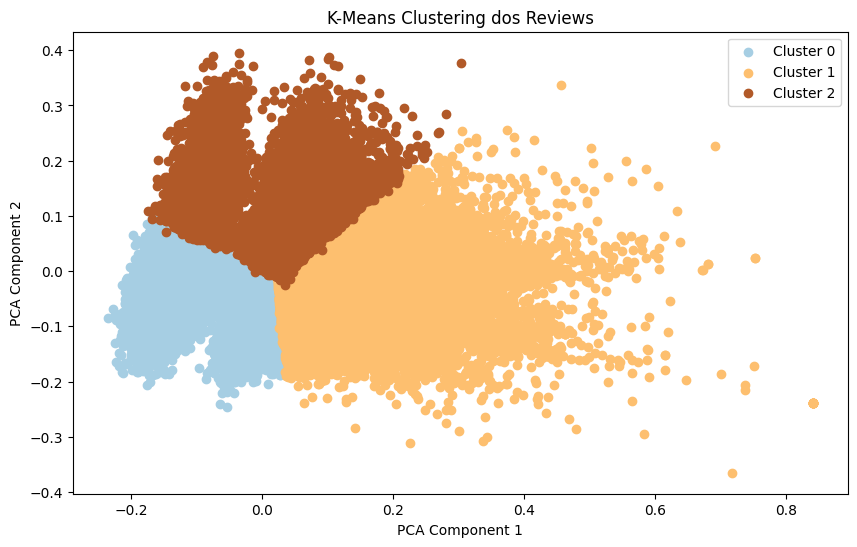

                                                 URL       Title  \
0  https://www.imdb.com/title/tt0137523/?ref_=ttl...  Fight Club   
1  https://www.imdb.com/title/tt0137523/?ref_=ttl...  Fight Club   
2  https://www.imdb.com/title/tt0137523/?ref_=ttl...  Fight Club   
3  https://www.imdb.com/title/tt0137523/?ref_=ttl...  Fight Club   
4  https://www.imdb.com/title/tt0137523/?ref_=ttl...  Fight Club   

   Release Year                                             Poster  Genre  \
0          1999  https://m.media-amazon.com/images/M/MV5BMmEzNT...  Drama   
1          1999  https://m.media-amazon.com/images/M/MV5BMmEzNT...  Drama   
2          1999  https://m.media-amazon.com/images/M/MV5BMmEzNT...  Drama   
3          1999  https://m.media-amazon.com/images/M/MV5BMmEzNT...  Drama   
4          1999  https://m.media-amazon.com/images/M/MV5BMmEzNT...  Drama   

        Director                                   Cast  Length  IMDB Rating  \
0  David Fincher  [Brad Pitt, Edward Norton, Mea

In [52]:
# Gerando os dados

# Plotar os clusters
plt.figure(figsize=(10, 6))
colors = plt.cm.Paired(np.linspace(0, 1, k))
for cluster in range(k):
    cluster_data = df[df["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], color=colors[cluster], label=f"Cluster {cluster}")
plt.title("K-Means Clustering dos Reviews")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# Exibir as primeiras linhas do DataFrame com os clusters adicionados
print(df.head())

## Parte 3: Classificação de Sentimentos Usando Redes Neurais (Embeddings com DistilBERT)

In [53]:
# Bibliotecas utilizadas

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertModel
import torch

In [54]:
# Criação de Categorias de Sentimento, Balanceamento de Classes e Geração de Embeddings com DistilBERT

# Se a coluna "Sentiment Category" não existir, cria-a a partir de "Rating By User"
def bin_sentiment(rating):
    if rating < 4:
        return "negative"
    elif rating <= 6:
        return "neutral"
    else:
        return "positive"

df = df.dropna(subset=["Rating By User"])
if "Sentiment Category" not in df.columns:
    df["Sentiment Category"] = df["Rating By User"].apply(bin_sentiment)

# Balanceamento das Classes
n_samples = 2500
df_neg = df[df["Sentiment Category"] == "negative"].sample(n_samples, random_state=42)
df_neu = df[df["Sentiment Category"] == "neutral"].sample(n_samples, random_state=42)
df_pos = df[df["Sentiment Category"] == "positive"].sample(n_samples, random_state=42)
df_balanced = pd.concat([df_neg, df_neu, df_pos]).reset_index(drop=True)
print("Distribuição das Classes Após Balanceamento:")
print(df_balanced["Sentiment Category"].value_counts())

# Gerar Embeddings dos Reviews Usando DistilBERT
tokenizer_nn = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model_nn_emb = DistilBertModel.from_pretrained("distilbert-base-uncased")

def get_embedding(text):
    encoded_input = tokenizer_nn(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        model_output = model_nn_emb(**encoded_input)
    # Utilizar o embedding do token [CLS] (primeiro token)
    cls_embedding = model_output.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().numpy()

embeddings_list = [get_embedding(text) for text in df_balanced["Review Text"].tolist()]
embeddings = np.array(embeddings_list)

# Mapear as classes para rótulos numéricos
mapping = {"negative": 0, "neutral": 1, "positive": 2}
df_balanced["label"] = df_balanced["Sentiment Category"].map(mapping)
labels = df_balanced["label"].values

Distribuição das Classes Após Balanceamento:
Sentiment Category
negative    2500
neutral     2500
positive    2500
Name: count, dtype: int64


c:\Users\dolby\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,883 (417.51 KB)

 Trainable params: 106,883 (417.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3747 - loss: 1.1128 - val_accuracy: 0.5683 - val_loss: 0.9972
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4892 - loss: 1.0131 - val_accuracy: 0.6183 - val_loss: 0.9018
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5826 - loss: 0.9214 - val_accuracy: 0.6367 - val_loss: 0.8407
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6143 - loss: 0.8541 - val_accuracy: 0.6467 - val_loss: 0.7901
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6365 - loss: 0.8159 - val_accuracy: 0.6450 - val_loss: 0.7490
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6394 - loss: 0.7997 - val_accuracy: 0.6750 - val_loss: 0.7173
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6642 - loss: 0.7571 - val_accuracy: 0.6717 - val_loss: 0.7140
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6415 - loss: 0.7605 - val_accuracy: 0.

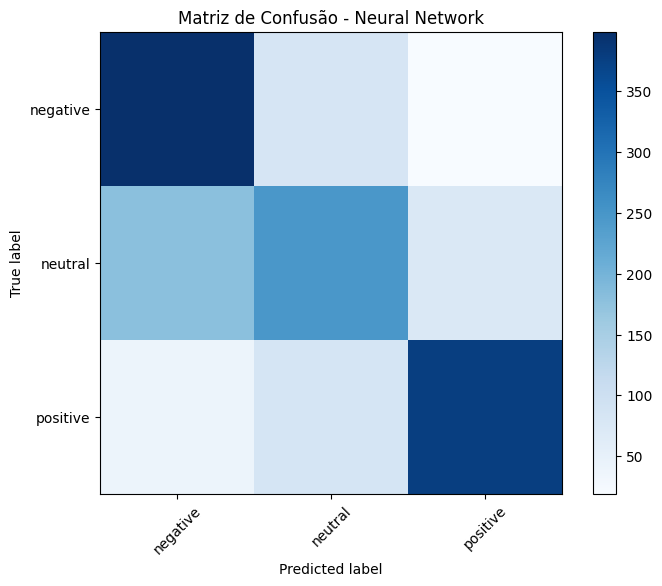

In [55]:
# Treinamento e Avaliação de um Modelo Neural (MLP) para Classificação de Sentimentos

# Dividir os Dados em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42, stratify=labels)

# Construir o Modelo Neural (MLP) com Keras
model_nn = models.Sequential([
    layers.Input(shape=(embeddings.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # 3 classes: negative, neutral, positive
])

model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
model_nn.summary()

# Treinar o Modelo
history = model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Avaliar o Modelo
loss, accuracy = model_nn.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.2f}")

y_pred_probs = model_nn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Neural Network")
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["negative", "neutral", "positive"], rotation=45)
plt.yticks(tick_marks, ["negative", "neutral", "positive"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()